# Background

NYC has a combined sewage system. This means that both stormwater and wastewater are collected into one sewer system to be conveyed to a wastewater resource recovery facility. Once at the facility, the water gets treated to be released into local waterways. However, during precipitation events, it is possible for the sewage system to go over capacity. When this happens, the system releases untreated sewage into local waterways through what are called a combined sewage overflows (CSOs). This can result in hazardous conditions in waterways as it is possible that harmful pathogens reach surface waters creating a risk for disease. New York's Department of Health and Mental Hygiene periodically tests NYC beaches for water quality. The main metric that is measured is the number of enterococci. While enterococci are not in their entirety hazardous, they are considered fecal indicator bacteria, as they can be indicative of the presence of E. Coli and other problematic bactera. The NYS Department of Health specifies that any single sample of surface water should not contain more than 104 enterococci colony forming units per 100 mL of marine water. The following model will use historical NYC beach water quality data provided by NYC OpenData, as well as precipitation and surface water temperature data provided by NOAA to predict the number of enterococci per 100 mL based on weather forecasts. With this quantification, it is then possible to classify the prediction as either being within standard, or over the 104 enterococci per 100 mL limit.

This model will analyze water quality in beaches near Eastchester Bay in the Throggs Neck area of The Bronx. This area is downstream of the Hutchinson River where multiple CSO outalls are located servicing the upper east Bronx area.

Multiple factors are accounted for in analyzing the data. The enterococci are attributed to an estimate of the population for the given date, the average surface water temperature, precipitation measurements which are given in inches for the day before the sample was collected and the actual day of collection.

### Libraries for Gradient Boosting Tree

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, truncnorm, uniform

### Read in the csv file containing the data of interest and show the head

In [2]:
enteroData = pd.read_csv('enteroData1.csv')
print(enteroData.shape)
enteroData.head()

(3560, 7)


,Sample Date,Enterococci Results,Year Population,Day Before Precipitation,Day of Precipitation,Water Temperature,Sum Precip
0,6/1/2005,4.0,7939571,0.0,0.0,15.23,0.0
1,6/1/2005,4.0,7939571,0.0,0.0,15.23,0.0
2,6/1/2005,4.0,7939571,0.0,0.0,15.23,0.0
3,6/1/2005,4.0,7939571,0.0,0.0,15.23,0.0
4,6/8/2005,4.0,7939571,0.0,0.0,17.89,0.0


### Data Correspondence

This chart shows the relationship between the enterococcus levels in the water and the precipitation received the day before the sample was taken

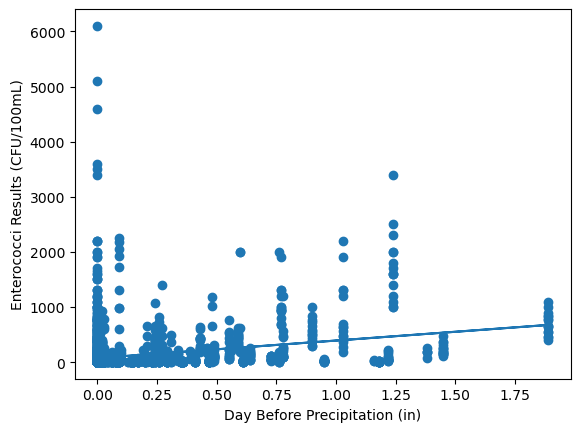

In [3]:
plt.scatter(enteroData['Day Before Precipitation'], enteroData['Enterococci Results'])
plt.xlabel("Day Before Precipitation (in)")
plt.ylabel("Enterococci Results (CFU/100mL)")
t = np.polyfit(enteroData['Day Before Precipitation'], enteroData['Enterococci Results'], 1)
p = np.poly1d(t)
plt.plot(enteroData['Day Before Precipitation'] ,p(enteroData['Day Before Precipitation']))

This chart shows the relationship between the enterococcus levels in the water and the precipitation received the day the sample was taken

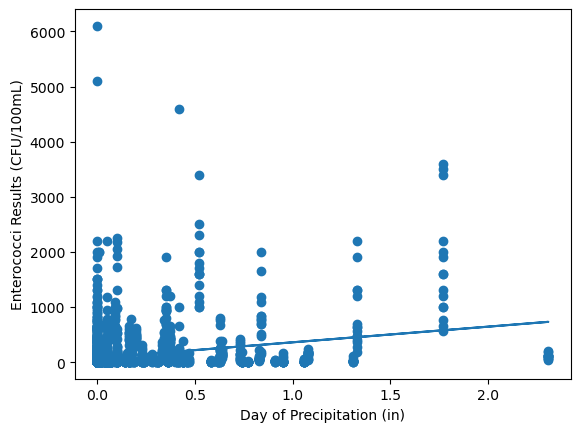

In [4]:
plt.scatter(enteroData['Day of Precipitation'], enteroData['Enterococci Results'])
plt.xlabel("Day of Precipitation (in)")
plt.ylabel("Enterococci Results (CFU/100mL)")
t = np.polyfit(enteroData['Day of Precipitation'], enteroData['Enterococci Results'], 1)
p = np.poly1d(t)
plt.plot(enteroData['Day of Precipitation'] ,p(enteroData['Day of Precipitation']))

This chart shows the relationship between the enterococcus levels in the water and the sum of the precipitation received the day the sample was taken, and the day prior to it

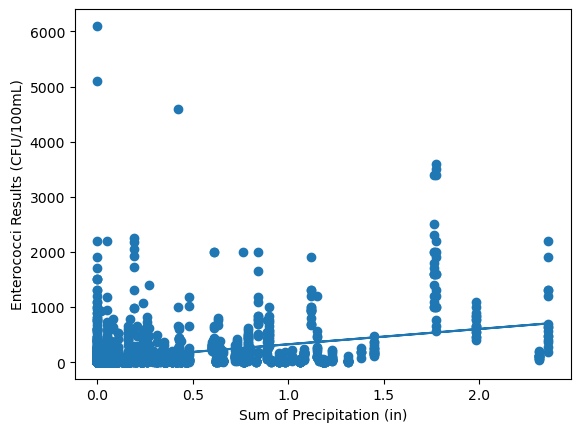

In [5]:
plt.scatter(enteroData['Sum Precip'], enteroData['Enterococci Results'])
plt.xlabel("Sum of Precipitation (in)")
plt.ylabel("Enterococci Results (CFU/100mL)")
t = np.polyfit(enteroData['Sum Precip'], enteroData['Enterococci Results'], 1)
p = np.poly1d(t)
plt.plot(enteroData['Sum Precip'] ,p(enteroData['Sum Precip']))

### Data Reduction for CSO Rainfall Data

Defining the Dependent Variable/Predictand

In [6]:
wetData = enteroData #[(enteroData['Day Before Precipitation'] >= 0.10) | (enteroData['Day of Precipitation'] >= 10)]

# The dependent variable, also called the label, is what we are trying to predict
# The labels DataFrame is first initiated like this for the visual representation
wetLabels = pd.DataFrame({"Enterococci Results": wetData['Enterococci Results']})
wetLabels.head()

,Enterococci Results
0,4.0
1,4.0
2,4.0
3,4.0
4,4.0


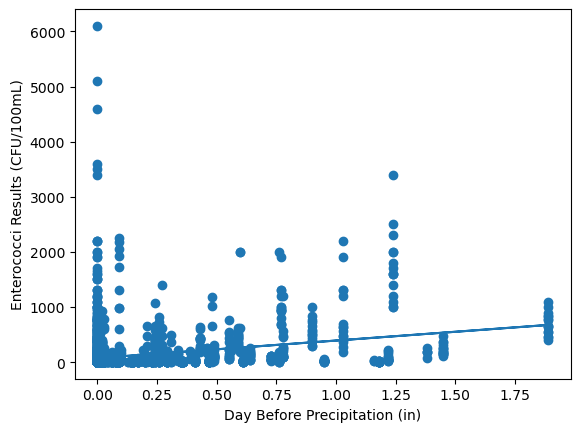

In [7]:
wetLabels = wetData['Enterococci Results']

plt.scatter(wetData['Day Before Precipitation'], wetData['Enterococci Results'])
plt.xlabel("Day Before Precipitation (in)")
plt.ylabel("Enterococci Results (CFU/100mL)")
t = np.polyfit(wetData['Day Before Precipitation'], wetData['Enterococci Results'], 1)
p = np.poly1d(t)
plt.plot(wetData['Day Before Precipitation'] ,p(wetData['Day Before Precipitation']))

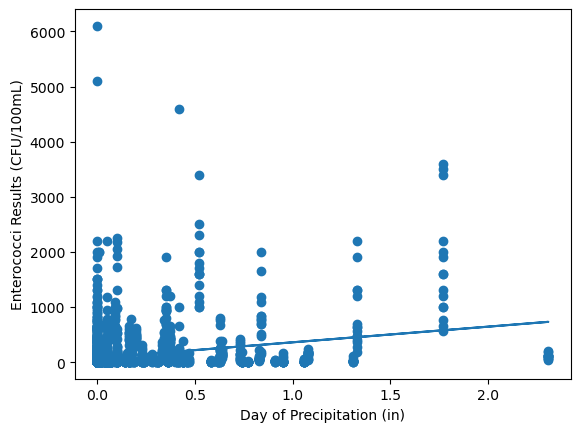

In [8]:
plt.scatter(wetData['Day of Precipitation'], wetData['Enterococci Results'])
plt.xlabel("Day of Precipitation (in)")
plt.ylabel("Enterococci Results (CFU/100mL)")
t = np.polyfit(wetData['Day of Precipitation'], wetData['Enterococci Results'], 1)
p = np.poly1d(t)
plt.plot(wetData['Day of Precipitation'] ,p(wetData['Day of Precipitation']))

Defining Independent Variables/Predictors

In [9]:
# Dropping dependent variable and Date
features = wetData.drop('Enterococci Results', axis=1)
features = features.drop('Sample Date', axis=1)

# Dependent Variables, also called features
featureList = list(features.columns)

print(features.shape)
features.head()

(3560, 5)


,Year Population,Day Before Precipitation,Day of Precipitation,Water Temperature,Sum Precip
0,7939571,0.0,0.0,15.23,0.0
1,7939571,0.0,0.0,15.23,0.0
2,7939571,0.0,0.0,15.23,0.0
3,7939571,0.0,0.0,15.23,0.0
4,7939571,0.0,0.0,17.89,0.0


### Making Data into NumPy Arrays

In [10]:
features = np.array(features)
labels = np.array(wetLabels)

### We will now split our dataset into training data and testing data

In [11]:
# As mentioned in article, we want our results to be reproducible, so we use a random_state = 42
trainFeatures, testFeatures, trainLabels, testLabels = train_test_split(features, labels, test_size = 0.2, random_state = 26)

print(trainFeatures.shape)
print(testFeatures.shape)
print(trainLabels.shape)
print(testLabels.shape)

(2848, 5)
(712, 5)
(2848,)
(712,)


## Creating the model

### Gradient Boosting Tree

We will first use base parameters to see the performance of the random forest under these conditions

In [12]:
params_gbt = {'n_estimators':1000,
              'criterion':'squared_error', 
              #'loss': 'absolute_error',
              'ccp_alpha':0.001,
              'max_depth': 10,
              'min_samples_leaf':1,
              'min_samples_split':5,
              'max_features':None}

gbt = GradientBoostingRegressor(**params_gbt)

gbt.fit(trainFeatures,trainLabels)

GradientBoostingRegressor(ccp_alpha=0.001, criterion='squared_error',
                          max_depth=10, min_samples_split=5, n_estimators=1000)

Making Predictions

Mean Absolute Error: 42720.24 cells/100mL.


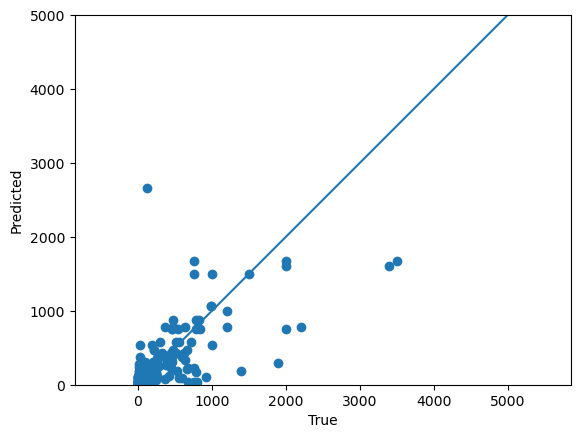

In [19]:
enteroPredictions = gbt.predict(testFeatures)
error = (enteroPredictions - testLabels)**2

plt.scatter(testLabels, enteroPredictions)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.axis('equal')
plt.xlim(0,5000)
plt.ylim(0, 5000)
_ = plt.plot([-100, 10000], [-100, 10000])

print('Mean Absolute Error:', round(np.mean(error), 2), 'cells/100mL.')

We can then look to find optimal hyperparameters by doing the following:

In [16]:
# Using methods from class

random_grid = {'n_estimators': randint(4, 2000),
               'criterion': ['squared_error'],
               'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
               'max_depth': randint(3, 1000),
               'min_samples_split': uniform(0.01, 0.199),
               'min_samples_leaf': uniform(0.01, 0.199)}

gbt2 = GradientBoostingRegressor(random_state=21)
gbt_random = RandomizedSearchCV(estimator = gbt2, param_distributions = random_grid, 
                                n_iter = 100, cv = 50, random_state = 21)
gbt_entero = gbt_random.fit(trainFeatures,trainLabels)
print("The best hyperparameters: \n",gbt_entero.best_params_)

The best hyperparameters: 
 {'criterion': 'squared_error', 'max_depth': 209, 'max_features': 0.32719618990475846, 'min_samples_leaf': 0.037793266429379975, 'min_samples_split': 0.08985800319765704, 'n_estimators': 761}


Mean Squared Error: 36989.63 cells/100mL.


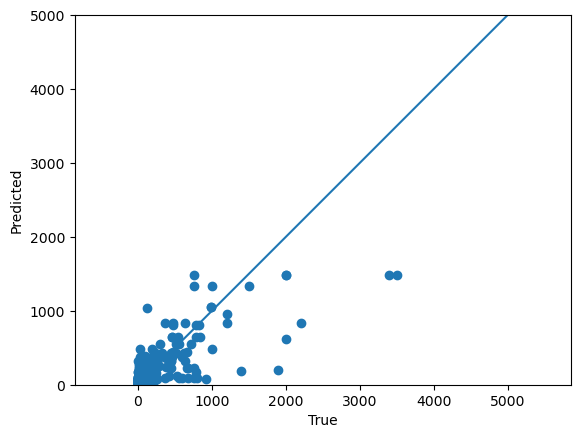

In [18]:
enteroPredictions = gbt_entero.predict(testFeatures)
error = (enteroPredictions - testLabels)**2

plt.scatter(testLabels, enteroPredictions)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.axis('equal')
plt.xlim(0,5000)
plt.ylim(0, 5000)
_ = plt.plot([-100, 10000], [-100, 10000])

print('Mean Squared Error:', round(np.mean(error), 2), 'cells/100mL.')

### Now an analysis will be done on whether or not the model can improve at higher values, if values below the CSO threshold are omitted